## Anti-Money Laundher Approach based on Project Aurora
1. **Based on the article here: [file]**
2.  **Key features**
        <br>- Synthetic data
        <br>- Graph database/queries
        <br>- Neural Network for predicting suspicious accounts

In [4]:
import pandas as pd
import numpy as np
from faker import Faker
import random
from datetime import datetime, timedelta
import os
import csv

# Initialize Faker
fake = Faker()

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


In [3]:
# Parameters based on Project Aurora
num_individuals = 800  # Number of individual accounts
num_businesses = 200   # Number of business accounts
num_transactions = 5000  # Total transactions
transaction_types = ['cash', 'wire', 'crypto', 'international']

# Curated list of real countries
countries = [
    'United States', 'Germany', 'Brazil', 'Japan', 'India', 'France', 'Canada',
    'Australia', 'South Africa', 'Mexico', 'United Kingdom', 'China', 'Italy', 'Spain'
]

# Generate entities (individuals and businesses)
individuals = [
    {
        'entity_id': f'I{str(i).zfill(4)}',
        'entity_type': 'individual',
        'name': fake.last_name(),
        'country': random.choice(countries)
    }
    for i in range(num_individuals)
]

business_names = [
    'Acme', 'Nexlify', 'Techtron', 'Globex', 'Innovex', 'Quantum', 'Synergy',
    'Vertex', 'OmniCorp', 'BrightPeak', 'Nexus', 'Strive', 'Pinnacle', 'CoreZap'
] * (num_businesses // 14 + 1)

businesses = [
    {
        'entity_id': f'B{str(i).zfill(4)}',
        'entity_type': 'business',
        'name': business_names[i],
        'country': random.choice(countries)
    }
    for i in range(num_businesses)
]

entities = individuals + businesses
entities_df = pd.DataFrame(entities)

# Validate entities_df
for idx, row in entities_df.iterrows():
    if len(row) != 4:
        print(f"Warning: Row {idx} in entities_df has {len(row)} columns: {row}")
    if any(c in row['name'] for c in [',', '"', ' ']):
        print(f"Warning: Row {idx} in entities_df has invalid characters in name: {row['name']}")

# Generate transactions with money laundering patterns
def generate_transaction(entities_df, idx, is_ml=False):
    valid_entity_ids = entities_df['entity_id'].values
    sender = np.random.choice(valid_entity_ids)
    
    receiver_candidates = entities_df[entities_df['entity_id'] != sender]['entity_id'].values
    if len(receiver_candidates) == 0:
        print(f"Warning: No valid receivers for sender {sender}")
        return None
    
    receiver = np.random.choice(receiver_candidates)
    
    if sender.startswith('T') or receiver.startswith('T'):
        print(f"Error: Invalid ID generated - sender: {sender}, receiver: {receiver}")
        return None
    
    if is_ml:
        amount = np.random.uniform(50, 900)  # Smurfing: small transactions
    else:
        amount = np.random.uniform(100, 10000)  # Normal transactions
    
    transaction_type = random.choice(transaction_types)
    timestamp = fake.date_time_between(start_date='-30d', end_date='now')
    
    sender_country = entities_df[entities_df['entity_id'] == sender]['country'].iloc[0]
    receiver_country = entities_df[entities_df['entity_id'] == receiver]['country'].iloc[0]
    is_cross_border = sender_country != receiver_country
    
    ml_flag = 1 if is_ml else 0
    
    return {
        'sender_id': sender,
        'receiver_id': receiver,
        'transaction_id': f'T{str(idx).zfill(5)}',
        'amount': round(amount, 2),
        'transaction_type': transaction_type,
        'timestamp': timestamp,
        'is_cross_border': is_cross_border,
        'ml_flag': ml_flag
    }

# Generate transactions
transactions = []
ml_transaction_count = int(num_transactions * 0.1)
i = 0
while len(transactions) < num_transactions:
    is_ml = i < ml_transaction_count
    if is_ml and i % 10 == 0:  # Simulate money mule network
        for _ in range(5):
            tx = generate_transaction(entities_df, len(transactions), is_ml=True)
            if tx:
                transactions.append(tx)
    else:
        tx = generate_transaction(entities_df, len(transactions), is_ml)
        if tx:
            transactions.append(tx)
    i += 1

# Create transactions_df with correct column order
transactions_df = pd.DataFrame(transactions, columns=[
    'sender_id', 'receiver_id', 'transaction_id', 'amount', 'transaction_type',
    'timestamp', 'is_cross_border', 'ml_flag'
])

# Validate transactions_df
valid_entity_ids = set(entities_df['entity_id'])
for idx, row in transactions_df.iterrows():
    if len(row) != 8:
        print(f"Warning: Row {idx} in transactions_df has {len(row)} columns: {row}")
    if row['sender_id'] not in valid_entity_ids:
        print(f"Error: Invalid sender_id {row['sender_id']} in transaction {row['transaction_id']}")
    if row['receiver_id'] not in valid_entity_ids:
        print(f"Error: Invalid receiver_id {row['receiver_id']} in transaction {row['transaction_id']}")
    if row['sender_id'].startswith('T') or row['receiver_id'].startswith('T'):
        print(f"Error: Transaction-like ID in transaction {row['transaction_id']}: sender_id={row['sender_id']}, receiver_id={row['receiver_id']}")

# Save to CSV with quoting
entities_df.to_csv('entities.csv', index=False, quoting=csv.QUOTE_ALL)
transactions_df.to_csv('transactions.csv', index=False, quoting=csv.QUOTE_ALL)

print(f"Synthetic data generated: entities.csv ({len(entities_df)} entities) and transactions.csv ({len(transactions_df)} transactions)")

Synthetic data generated: entities.csv (1000 entities) and transactions.csv (5000 transactions)


In [6]:
import kuzu
import os

# Initialize Kuzu database
db = kuzu.Database('kuzu_db')
conn = kuzu.Connection(db)

In [ ]:

# Create node and relationship tables
conn.execute("""
    CREATE NODE TABLE Entity(
        entity_id STRING,
        entity_type STRING,
        name STRING,
        country STRING,
        PRIMARY KEY (entity_id)
    )
""")

conn.execute("""
    CREATE REL TABLE Transaction(
        FROM Entity TO Entity,
        transaction_id STRING,
        amount DOUBLE,
        transaction_type STRING,
        timestamp TIMESTAMP,
        is_cross_border BOOLEAN,
        ml_flag INT
    )
""")


In [ ]:
# Load entities from CSV with explicit CSV options

conn.execute("""
    COPY Entity FROM 'entities.csv' (HEADER=TRUE, DELIM=',', QUOTE='"')
""")

# Load transactions from CSV with explicit CSV options
conn.execute("""
    COPY Transaction FROM 'transactions.csv' (HEADER=TRUE, DELIM=',', QUOTE='"')
""")

In [7]:

# Example Cypher queries for analysis
# Query 1: Find high-degree nodes (potential money mules)
result = conn.execute("""
    MATCH (e:Entity)-[t:Transaction]->()
    RETURN e.entity_id, e.name, e.country, COUNT(t) AS degree
    ORDER BY degree DESC
    LIMIT 10
""")
print("\nTop 10 high-degree nodes:")
while result.has_next():
    row = result.get_next()
    print(row)


# Query 3: Detect smurfing (small transactions below threshold)
result = conn.execute("""
    MATCH (e:Entity)-[t:Transaction]->()
    WHERE t.amount < 1000
    RETURN e.entity_id, COUNT(t) AS small_tx_count
    ORDER BY small_tx_count DESC
    LIMIT 10
""")
print("\nPotential smurfing (small transactions):")
while result.has_next():
    row = result.get_next()
    print(row)


Top 10 high-degree nodes:
['I0272', 'Nguyen', 'Germany', 15]
['I0068', 'Oliver', 'Spain', 13]
['B0128', 'Techtron', 'Australia', 12]
['I0699', 'Jackson', 'Italy', 12]
['B0032', 'Innovex', 'Spain', 11]
['I0556', 'Rodriguez', 'Brazil', 11]
['I0074', 'Barnett', 'Japan', 11]
['I0559', 'Wood', 'Brazil', 11]
['I0549', 'Carlson', 'Spain', 11]
['I0661', 'Schaefer', 'United Kingdom', 11]


________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

## Neural Network


In [1]:
import kuzu
import os

# Check if database exists, connect or create
db_path = 'kuzu_db'
if not os.path.exists(db_path):
    print("Creating new Kuzu database")
    db = kuzu.Database(db_path)
    conn = kuzu.Connection(db)
    # Initialize schema and load data
    conn.execute("CREATE NODE TABLE Entity(entity_id STRING, PRIMARY KEY(entity_id))")
    conn.execute("CREATE REL TABLE Transaction(FROM Entity TO Entity, amount DOUBLE, is_cross_border BOOLEAN, ml_flag INT)")
    conn.execute("COPY Entity FROM 'entities.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
    conn.execute("COPY Transaction FROM 'transactions.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
else:
    print("Connecting to existing Kuzu database")
    db = kuzu.Database(db_path)
    conn = kuzu.Connection(db)

# Verify database state
result = conn.execute("MATCH (e:Entity) RETURN COUNT(e)")
num_entities = result.get_next()[0]
result = conn.execute("MATCH ()-[t:Transaction]->() RETURN COUNT(t)")
num_transactions = result.get_next()[0]
print(f"Number of entities: {num_entities}")
print(f"Number of transactions: {num_transactions}")
if num_entities == 0 or num_transactions == 0:
    raise ValueError("Database is empty. Ensure entities.csv and transactions.csv are loaded.")

Connecting to existing Kuzu database
Number of entities: 1000
Number of transactions: 5000


In [21]:
# Imports for NN
import pandas as pd
import numpy as np
import kuzu
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import os

In [30]:
# Query 1: Get degree (outgoing transactions)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS degree
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in degree query: {num_tuples}")
    if num_tuples == 0:
        raise ValueError("Degree query returned no results.")
    degree_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                            columns=['entity_id', 'degree'])
    degree_df['degree'] = pd.to_numeric(degree_df['degree'], errors='coerce')
    print("Degree query successful")
    print(degree_df.head())
except Exception as e:
    print(f"Error executing degree query: {e}")
    raise

# Query 3: Get small transaction count (amount < 1000)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        WHERE t.amount < 1000
        RETURN e.entity_id, COUNT(t) AS small_tx_count
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in small transaction query: {num_tuples}")
    small_tx_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                              columns=['entity_id', 'small_tx_count'])
    small_tx_df['small_tx_count'] = pd.to_numeric(small_tx_df['small_tx_count'], errors='coerce')
except Exception as e:
    print(f"Error executing small transaction query: {e}")
    raise

# Additional features: Average amount, cross-border ratio, max amount, in-degree, transaction frequency, amount variance
try:
    result = conn.execute("""
        MATCH (e:Entity)
        OPTIONAL MATCH (e)-[t:Transaction]->()
        OPTIONAL MATCH ()-[t_in:Transaction]->(e)
        WITH e, t, t_in, AVG(t.amount) AS avg_amount
        RETURN e.entity_id, 
               COALESCE(avg_amount, 0) AS avg_amount, 
               COALESCE(SUM(CASE WHEN t.is_cross_border THEN 1 ELSE 0 END) / NULLIF(COUNT(t), 0), 0) AS cross_border_ratio,
               COALESCE(MAX(t.amount), 0) AS max_amount,
               COALESCE(COUNT(t_in), 0) AS in_degree,
               COALESCE(COUNT(t), 0) AS tx_frequency,
               COALESCE(
                   SQRT(
                       SUM(CASE WHEN t.amount IS NOT NULL THEN (t.amount - avg_amount)^2 ELSE 0 END) / 
                       NULLIF(COUNT(t), 0)
                   ), 0
               ) AS amount_variance
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in features query: {num_tuples}")
    features_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                              columns=['entity_id', 'avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance'])
    features_df[['avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance']] = features_df[
        ['avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance']
    ].apply(pd.to_numeric, errors='coerce')
    print("Features query successful")
    print(features_df.head())
except Exception as e:
    print(f"Error executing features query: {e}")
    raise

# Merge features and handle NaN
data_df = degree_df.merge(small_tx_df, on='entity_id', how='left').merge(features_df, on='entity_id', how='left')
data_df.fillna({'small_tx_count': 0, 'avg_amount': 0, 'cross_border_ratio': 0, 'max_amount': 0, 'in_degree': 0, 'tx_frequency': 0, 'amount_variance': 0}, inplace=True)
print("Merged data_df:")
print(data_df.head())
print("DataFrame info:")
print(data_df.dtypes)
print("NaN counts:")
print(data_df.isna().sum())

# Create labels (same as previous: small_tx_count >= 3 or cross_border_ratio > 0.8)
data_df['label'] = ((data_df['small_tx_count'] >= 3) | (data_df['cross_border_ratio'] > 0.8)).astype(int)

# Prepare features and labels
feature_columns = ['degree', 'small_tx_count', 'avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance']
X = data_df[feature_columns].values
y = data_df['label'].values

# Verify X for non-numeric values
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values (NaN or inf)")
    print("Rows with issues:", np.where(~np.isfinite(X))[0])
    print("Columns with issues:", [feature_columns[i] for i in np.where(~np.isfinite(X))[1]])
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Verify scaling
print("X after scaling:")
print(X[:5])
print("Any NaN in X:", np.any(np.isnan(X)))
print("Any inf in X:", np.any(np.isinf(X)))

# Compute class weights
class_weights = {0: 1.0, 1: 3.0}
print(f"Class weights: {class_weights}")


Number of tuples in degree query: 995
Degree query successful
  entity_id  degree
0     I0284       7
1     I0111       9
2     B0196       8
3     I0450       4
4     I0491       6
Number of tuples in small transaction query: 689
Number of tuples in features query: 5005
Features query successful
  entity_id  avg_amount  cross_border_ratio  max_amount  in_degree  \
0     I0395      548.30                 0.0      548.30          6   
1     I0399     7549.44                 0.0     7549.44          1   
2     I0403     6014.55                 0.0     6014.55          3   
3     I0411     7536.66                 0.0     7536.66          6   
4     I0411     2446.11                 0.0     2446.11          6   

   tx_frequency  amount_variance  
0             6              0.0  
1             1              0.0  
2             3              0.0  
3             6              0.0  
4             6              0.0  
Merged data_df:
  entity_id  degree  small_tx_count  avg_amount  cross_

In [31]:

# Neural network classes (with batch normalization)
class BatchNormalization:
    def __init__(self, n_features, momentum=0.9, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = np.zeros((1, n_features))
        self.running_var = np.ones((1, n_features))
        self.gamma = np.ones((1, n_features))
        self.beta = np.zeros((1, n_features))
    
    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:
            self.mean = np.mean(inputs, axis=0, keepdims=True)
            self.var = np.var(inputs, axis=0, keepdims=True)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.mean = self.running_mean
            self.var = self.running_var
        self.normalized = (inputs - self.mean) / np.sqrt(self.var + self.epsilon)
        self.output = self.gamma * self.normalized + self.beta
        return self.output
    
    def backward(self, dvalues):
        N = dvalues.shape[0]
        self.dgamma = np.sum(dvalues * self.normalized, axis=0, keepdims=True)
        self.dbeta = np.sum(dvalues, axis=0, keepdims=True)
        dnormalized = dvalues * self.gamma
        dvar = np.sum(dnormalized * (self.inputs - self.mean) * -0.5 * (self.var + self.epsilon) ** -1.5, axis=0, keepdims=True)
        dmean = np.sum(dnormalized * -1 / np.sqrt(self.var + self.epsilon), axis=0, keepdims=True) + dvar * np.mean(-2 * (self.inputs - self.mean), axis=0, keepdims=True)
        self.dinputs = dnormalized / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.inputs - self.mean) / N + dmean / N
        return self.dinputs

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, l2_lambda=0.03):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.l2_lambda = l2_lambda
    def forward(self, inputs, training=True):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Layer_Dense:", self.output)
        return self.output
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues) + self.l2_lambda * self.weights
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Dropout:
    def __init__(self, rate):
        self.rate = rate
    def forward(self, inputs, training=True):
        self.inputs = inputs
        if not training:
            self.output = inputs
        else:
            self.mask = np.random.binomial(1, 1 - self.rate, size=inputs.shape) / (1 - self.rate)
            self.output = inputs * self.mask
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues * self.mask

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Activation_ReLU:", self.output)
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-np.clip(inputs, -500, 500)))
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Activation_Sigmoid:", self.output)
        return self.output
    def backward(self, dvalues):
        if dvalues.shape != self.output.shape:
            print(f"Shape mismatch in Activation_Sigmoid.backward: dvalues={dvalues.shape}, output={self.output.shape}")
            raise ValueError("Shape mismatch in sigmoid backward pass")
        self.dinputs = dvalues * self.output * (1 - self.output)
        return self.dinputs

class Loss_BinaryCrossEntropy:
    def calculate(self, output, y):
        y = y.reshape(-1, 1)
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)
        loss = -np.mean(y * np.log(clipped_output) + (1 - y) * np.log(1 - clipped_output))
        return loss
    def calculate_weighted(self, output, y, class_weights):
        y = y.reshape(-1, 1)
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)
        loss = -(y * np.log(clipped_output) + (1 - y) * np.log(1 - clipped_output))
        weights = np.where(y == 1, class_weights[1], class_weights[0])
        return np.mean(loss * weights)
    def backward(self, dvalues, y):
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        y = y.reshape(-1, 1)
        self.dinputs = -(y / clipped_dvalues - (1 - y) / (1 - clipped_dvalues)) / len(y)
        self.dinputs = self.dinputs.reshape(-1, 1)
        return self.dinputs


## VARIATIONS ON NEURAL NETWORKS
_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________


In [32]:

# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
train_accuracies_all = []
val_accuracies_all = []
train_losses_all = []
val_losses_all = []

for train_idx, val_idx in kf.split(X):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
    print(f"Suspicious entities (label=1): {np.mean(y_train):.4f}")

    # Initialize network
    layer1 = Layer_Dense(8, 8, l2_lambda=0.03)
    bn1 = BatchNormalization(8)
    relu1 = Activation_ReLU()
    dropout1 = Dropout(0.6)
    layer2 = Layer_Dense(8, 1, l2_lambda=0.03)
    sigmoid = Activation_Sigmoid()
    loss_function = Loss_BinaryCrossEntropy()

    # Momentum parameters
    momentum = 0.6
    velocity_w1 = np.zeros_like(layer1.weights)
    velocity_b1 = np.zeros_like(layer1.biases)
    velocity_w2 = np.zeros_like(layer2.weights)
    velocity_b2 = np.zeros_like(layer2.biases)

    # Training loop
    learning_rate = 0.0005
    epochs = 1000
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience = 50
    no_improve_epochs = 0
    prediction_threshold = 0.5

    for epoch in range(epochs):
        # Forward pass (training)
        layer1.forward(X_train, training=True)
        bn1.forward(layer1.output, training=True)
        relu1.forward(bn1.output)
        dropout1.forward(relu1.output, training=True)
        layer2.forward(dropout1.output, training=True)
        train_output = sigmoid.forward(layer2.output)
        
        # Training loss (weighted)
        train_loss = loss_function.calculate_weighted(train_output, y_train, class_weights)
        train_losses.append(train_loss)
        
        # Training accuracy
        train_predictions = (train_output > prediction_threshold).flatten()
        train_accuracy = np.mean(train_predictions == y_train)
        train_accuracies.append(train_accuracy)
        
        # Backward pass (training)
        loss_function.backward(train_output, y_train)
        sigmoid.backward(loss_function.dinputs)
        layer2.backward(sigmoid.dinputs)
        dropout1.backward(layer2.dinputs)
        relu1.backward(dropout1.dinputs)
        bn1.backward(relu1.dinputs)
        layer1.backward(bn1.dinputs)
        
        # Update weights and biases with momentum
        velocity_w1 = momentum * velocity_w1 - learning_rate * layer1.dweights
        velocity_b1 = momentum * velocity_b1 - learning_rate * layer1.dbiases
        velocity_w2 = momentum * velocity_w2 - learning_rate * layer2.dweights
        velocity_b2 = momentum * velocity_b2 - learning_rate * layer2.dbiases
        
        layer1.weights += velocity_w1
        layer1.biases += velocity_b1
        layer2.weights += velocity_w2
        layer2.biases += velocity_b2
        
        # Validation metrics
        layer1.forward(X_val, training=False)
        bn1.forward(layer1.output, training=False)
        relu1.forward(bn1.output)
        dropout1.forward(relu1.output, training=False)
        layer2.forward(dropout1.output, training=False)
        val_output = sigmoid.forward(layer2.output)
        
        val_loss = loss_function.calculate(val_output, y_val)
        val_losses.append(val_loss)
        
        val_predictions = (val_output > prediction_threshold).flatten()
        val_accuracy = np.mean(val_predictions == y_val)
        val_accuracies.append(val_accuracy)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
        if epoch % 100 == 0:
            print(f"Fold {fold}, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
            print(f"Train predictions (first 10): {train_predictions[:10]}")
            print(f"Train output probabilities (first 10): {train_output[:10].flatten()}")
            print(f"Validation predictions (first 10): {val_predictions[:10]}")
            print(f"Validation output probabilities (first 10): {val_output[:10].flatten()}")
            print(f"Train predictions (all): {np.unique(train_predictions, return_counts=True)}")
            print(f"Validation predictions (all): {np.unique(val_predictions, return_counts=True)}")

    train_accuracies_all.append(train_accuracies)
    val_accuracies_all.append(val_accuracies)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    fold += 1

# Average metrics across folds
avg_train_accuracy = np.mean([acc[-1] for acc in train_accuracies_all])
avg_val_accuracy = np.mean([acc[-1] for acc in val_accuracies_all])
avg_train_loss = np.mean([loss[-1] for loss in train_losses_all])
avg_val_loss = np.mean([loss[-1] for loss in val_losses_all])
print(f"\nAverage Train Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Val Accuracy: {avg_val_accuracy:.4f}")
print(f"Average Train Loss: {avg_train_loss:.4f}")
print(f"Average Val Loss: {avg_val_loss:.4f}")



Fold 1
Training samples: 4000, Validation samples: 1000
Suspicious entities (label=1): 0.1462
Fold 1, Epoch 0, Train Loss: 0.8993, Val Loss: 0.6931, Train Accuracy: 0.3852, Val Accuracy: 0.5460
Train predictions (first 10): [ True False  True False  True  True  True False  True  True]
Train output probabilities (first 10): [0.51010724 0.5        0.50508966 0.5        0.50010515 0.50042262
 0.50067239 0.5        0.51413686 0.51258496]
Validation predictions (first 10): [ True  True  True  True False False  True False  True False]
Validation output probabilities (first 10): [0.50012201 0.50004459 0.50002283 0.50001489 0.49989592 0.49996871
 0.50002013 0.49994715 0.50014297 0.49999049]
Train predictions (all): (array([False,  True]), array([1560, 2440]))
Validation predictions (all): (array([False,  True]), array([566, 434]))
Fold 1, Epoch 100, Train Loss: 0.8635, Val Loss: 0.6551, Train Accuracy: 0.8872, Val Accuracy: 0.8580
Train predictions (first 10): [False False False False False F

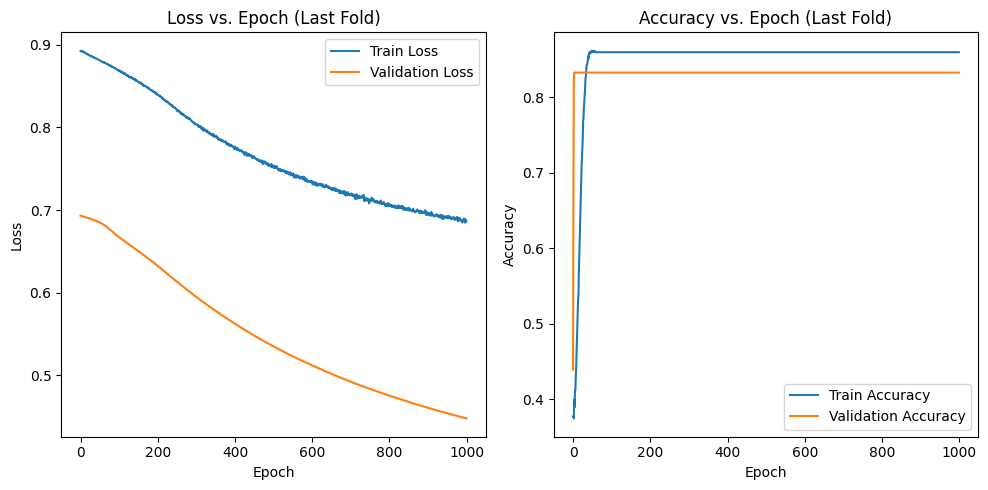

Feature correlations with label:
degree                0.335011
small_tx_count        0.739427
avg_amount           -0.160262
cross_border_ratio         NaN
max_amount           -0.160262
in_degree            -0.007215
tx_frequency         -0.008420
amount_variance            NaN
Name: label, dtype: float64


In [33]:

# Plot metrics (last fold)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epoch (Last Fold)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch (Last Fold)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Feature correlation analysis
print("Feature correlations with label:")
correlations = data_df[feature_columns + ['label']].corr()['label'].drop('label')
print(correlations)

**BINARY**

Generated 5000 entities and 25000 transactions
Creating new Kuzu database
Number of entities: 5000
Number of transactions: 25000
Number of tuples in degree query: 4970
Degree query successful
  entity_id  degree
0     E2381       9
1     E4234       8
2     E1244       8
3     E2175       5
4     E2785       4
Number of tuples in small transaction query: 2955
Number of tuples in features query: 5000
Features query successful
  entity_id   avg_amount  cross_border_ratio    max_amount  in_degree  \
0     E4681  5064.950176                 0.0  25547.761635         32   
1     E4683  4336.848368                 0.0   9472.022051         64   
2     E4728  8572.971817                 0.0  13162.073863         36   
3     E4734  8977.032198                 0.0  20487.595124         48   
4     E4743  3929.265125                 0.0   6613.205838         16   

   tx_frequency  
0            32  
1            64  
2            36  
3            48  
4            16  
Merged data_df:
  entity

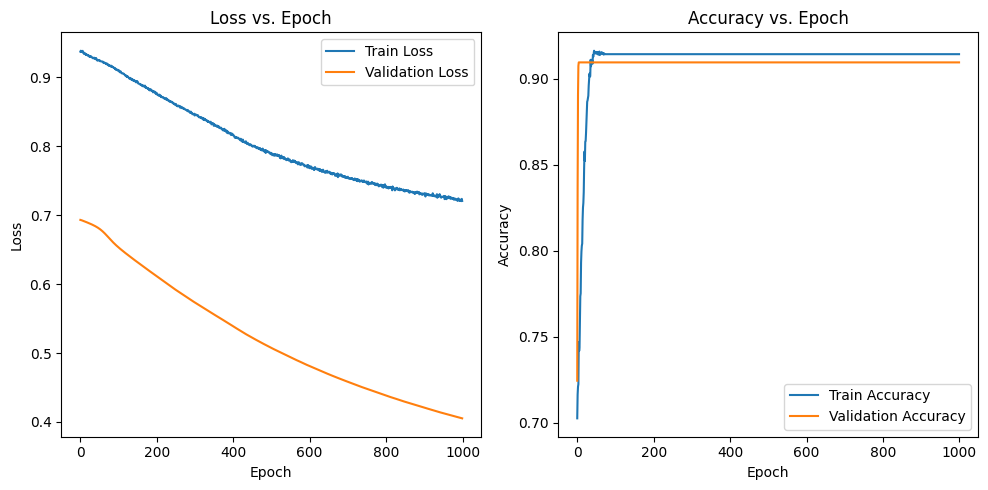

Final Train Accuracy: 0.9142
Final Val Accuracy: 0.9095
Feature correlations with label:
degree                0.114249
small_tx_count        0.506072
avg_amount           -0.130348
cross_border_ratio    0.510459
max_amount           -0.045402
in_degree             0.085372
tx_frequency          0.086528
Name: label, dtype: float64


In [5]:
import pandas as pd
import numpy as np
import kuzu
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os

# Synthetic data generation (optional)
def generate_synthetic_data(num_entities=5000, num_transactions=25000):
    np.random.seed(42)
    entities = pd.DataFrame({'entity_id': [f'E{i:04d}' for i in range(num_entities)]})
    transactions = pd.DataFrame({
        'sender_id': np.random.choice(entities['entity_id'], num_transactions),
        'receiver_id': np.random.choice(entities['entity_id'], num_transactions),
        'amount': np.random.exponential(5000, num_transactions).clip(100, 100000),
        'is_cross_border': np.random.choice([True, False], num_transactions, p=[0.3, 0.7]),
        'ml_flag': np.random.choice([1, 0], num_transactions, p=[0.05, 0.95])
    })
    entities.to_csv('entities.csv', index=False)
    transactions.to_csv('transactions.csv', index=False)
    print(f"Generated {num_entities} entities and {num_transactions} transactions")

# Uncomment to generate synthetic data (x5 sample size)
generate_synthetic_data()

# Check if database exists, connect or create
db_path = 'kuzu_db'
if not os.path.exists(db_path):
    print("Creating new Kuzu database")
    db = kuzu.Database(db_path)
    conn = kuzu.Connection(db)
    conn.execute("CREATE NODE TABLE Entity(entity_id STRING, PRIMARY KEY(entity_id))")
    conn.execute("CREATE REL TABLE Transaction(FROM Entity TO Entity, amount DOUBLE, is_cross_border BOOLEAN, ml_flag INT)")
    conn.execute("COPY Entity FROM 'entities.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
    conn.execute("COPY Transaction FROM 'transactions.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
else:
    print("Connecting to existing Kuzu database")
    db = kuzu.Database(db_path)
    conn = kuzu.Connection(db)

# Verify database state
result = conn.execute("MATCH (e:Entity) RETURN COUNT(e)")
num_entities = result.get_next()[0]
result = conn.execute("MATCH ()-[t:Transaction]->() RETURN COUNT(t)")
num_transactions = result.get_next()[0]
print(f"Number of entities: {num_entities}")
print(f"Number of transactions: {num_transactions}")
if num_entities == 0 or num_transactions == 0:
    raise ValueError("Database is empty. Ensure entities.csv and transactions.csv are loaded.")

# Query 1: Get degree (outgoing transactions)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS degree
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in degree query: {num_tuples}")
    if num_tuples == 0:
        raise ValueError("Degree query returned no results.")
    degree_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                            columns=['entity_id', 'degree'])
    degree_df['degree'] = pd.to_numeric(degree_df['degree'], errors='coerce')
    print("Degree query successful")
    print(degree_df.head())
except Exception as e:
    print(f"Error executing degree query: {e}")
    raise

# Query 3: Get small transaction count (amount < 1000)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        WHERE t.amount < 1000
        RETURN e.entity_id, COUNT(t) AS small_tx_count
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in small transaction query: {num_tuples}")
    small_tx_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                              columns=['entity_id', 'small_tx_count'])
    small_tx_df['small_tx_count'] = pd.to_numeric(small_tx_df['small_tx_count'], errors='coerce')
except Exception as e:
    print(f"Error executing small transaction query: {e}")
    raise

# Additional features: Average amount, cross-border ratio, max amount, in-degree, transaction frequency
try:
    result = conn.execute("""
        MATCH (e:Entity)
        OPTIONAL MATCH (e)-[t:Transaction]->()
        OPTIONAL MATCH ()-[t_in:Transaction]->(e)
        RETURN e.entity_id, 
               COALESCE(AVG(t.amount), 0) AS avg_amount, 
               COALESCE(SUM(CASE WHEN t.is_cross_border THEN 1 ELSE 0 END) / NULLIF(COUNT(t), 0), 0) AS cross_border_ratio,
               COALESCE(MAX(t.amount), 0) AS max_amount,
               COALESCE(COUNT(t_in), 0) AS in_degree,
               COALESCE(COUNT(t), 0) AS tx_frequency
    """)
    num_tuples = result.get_num_tuples()
    print(f"Number of tuples in features query: {num_tuples}")
    features_df = pd.DataFrame([result.get_next() for _ in range(num_tuples)], 
                              columns=['entity_id', 'avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency'])
    features_df[['avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency']] = features_df[
        ['avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency']
    ].apply(pd.to_numeric, errors='coerce')
    print("Features query successful")
    print(features_df.head())
except Exception as e:
    print(f"Error executing features query: {e}")
    raise

# Merge features and handle NaN
data_df = degree_df.merge(small_tx_df, on='entity_id', how='left').merge(features_df, on='entity_id', how='left')
data_df.fillna({'small_tx_count': 0, 'avg_amount': 0, 'cross_border_ratio': 0, 'max_amount': 0, 'in_degree': 0, 'tx_frequency': 0}, inplace=True)
print("Merged data_df:")
print(data_df.head())
print("DataFrame info:")
print(data_df.dtypes)
print("NaN counts:")
print(data_df.isna().sum())

# Create labels (tightened: small_tx_count >= 3 or cross_border_ratio > 0.8)
data_df['label'] = ((data_df['small_tx_count'] >= 3) | (data_df['cross_border_ratio'] > 0.8)).astype(int)

# Prepare features and labels
feature_columns = ['degree', 'small_tx_count', 'avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency']
X = data_df[feature_columns].values
y = data_df['label'].values

# Verify X for non-numeric values
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values (NaN or inf)")
    print("Rows with issues:", np.where(~np.isfinite(X))[0])
    print("Columns with issues:", [feature_columns[i] for i in np.where(~np.isfinite(X))[1]])
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Verify scaling
print("X after scaling:")
print(X[:5])
print("Any NaN in X:", np.any(np.isnan(X)))
print("Any inf in X:", np.any(np.isinf(X)))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Suspicious entities (label=1): {np.mean(y):.4f}")

# Feature distribution analysis
print("Feature distributions by label:")
print(data_df.groupby('label')[feature_columns].mean())

# Compute class weights
class_weights = {0: 1.0, 1: 5.0}  # Reduced positive class weight
print(f"Class weights: {class_weights}")

# Neural network classes (with batch normalization)
class BatchNormalization:
    def __init__(self, n_features, momentum=0.9, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon
        self.running_mean = np.zeros((1, n_features))
        self.running_var = np.ones((1, n_features))
        self.gamma = np.ones((1, n_features))
        self.beta = np.zeros((1, n_features))
    
    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:
            self.mean = np.mean(inputs, axis=0, keepdims=True)
            self.var = np.var(inputs, axis=0, keepdims=True)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.mean = self.running_mean
            self.var = self.running_var
        self.normalized = (inputs - self.mean) / np.sqrt(self.var + self.epsilon)
        self.output = self.gamma * self.normalized + self.beta
        return self.output
    
    def backward(self, dvalues):
        N = dvalues.shape[0]
        self.dgamma = np.sum(dvalues * self.normalized, axis=0, keepdims=True)
        self.dbeta = np.sum(dvalues, axis=0, keepdims=True)
        dnormalized = dvalues * self.gamma
        dvar = np.sum(dnormalized * (self.inputs - self.mean) * -0.5 * (self.var + self.epsilon) ** -1.5, axis=0, keepdims=True)
        dmean = np.sum(dnormalized * -1 / np.sqrt(self.var + self.epsilon), axis=0, keepdims=True) + dvar * np.mean(-2 * (self.inputs - self.mean), axis=0, keepdims=True)
        self.dinputs = dnormalized / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.inputs - self.mean) / N + dmean / N
        return self.dinputs

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, l2_lambda=0.02):  # Increased L2 regularization
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        self.l2_lambda = l2_lambda
    def forward(self, inputs, training=True):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Layer_Dense:", self.output)
        return self.output
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues) + self.l2_lambda * self.weights
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Dropout:
    def __init__(self, rate):
        self.rate = rate
    def forward(self, inputs, training=True):
        self.inputs = inputs
        if not training:
            self.output = inputs
        else:
            self.mask = np.random.binomial(1, 1 - self.rate, size=inputs.shape) / (1 - self.rate)
            self.output = inputs * self.mask
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues * self.mask

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Activation_ReLU:", self.output)
        return self.output
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-np.clip(inputs, -500, 500)))
        if not np.all(np.isfinite(self.output)):
            print("Warning: Invalid output in Activation_Sigmoid:", self.output)
        return self.output
    def backward(self, dvalues):
        if dvalues.shape != self.output.shape:
            print(f"Shape mismatch in Activation_Sigmoid.backward: dvalues={dvalues.shape}, output={self.output.shape}")
            raise ValueError("Shape mismatch in sigmoid backward pass")
        self.dinputs = dvalues * self.output * (1 - self.output)
        return self.dinputs

class Loss_BinaryCrossEntropy:
    def calculate(self, output, y):
        y = y.reshape(-1, 1)
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)
        loss = -np.mean(y * np.log(clipped_output) + (1 - y) * np.log(1 - clipped_output))
        return loss
    def calculate_weighted(self, output, y, class_weights):
        y = y.reshape(-1, 1)
        clipped_output = np.clip(output, 1e-7, 1 - 1e-7)
        loss = -(y * np.log(clipped_output) + (1 - y) * np.log(1 - clipped_output))
        weights = np.where(y == 1, class_weights[1], class_weights[0])
        return np.mean(loss * weights)
    def backward(self, dvalues, y):
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        y = y.reshape(-1, 1)
        self.dinputs = -(y / clipped_dvalues - (1 - y) / (1 - clipped_dvalues)) / len(y)
        self.dinputs = self.dinputs.reshape(-1, 1)
        return self.dinputs

# Initialize network with simpler architecture
layer1 = Layer_Dense(7, 8, l2_lambda=0.02)
bn1 = BatchNormalization(8)
relu1 = Activation_ReLU()
dropout1 = Dropout(0.5)  # Increased dropout
layer2 = Layer_Dense(8, 1, l2_lambda=0.02)
sigmoid = Activation_Sigmoid()
loss_function = Loss_BinaryCrossEntropy()

# Momentum parameters
momentum = 0.6
velocity_w1 = np.zeros_like(layer1.weights)
velocity_b1 = np.zeros_like(layer1.biases)
velocity_w2 = np.zeros_like(layer2.weights)
velocity_b2 = np.zeros_like(layer2.biases)

# Training loop with early stopping
learning_rate = 0.0005
epochs = 1000
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 50
no_improve_epochs = 0
prediction_threshold = 0.5  # Standard threshold

for epoch in range(epochs):
    # Forward pass (training)
    layer1.forward(X_train, training=True)
    bn1.forward(layer1.output, training=True)
    relu1.forward(bn1.output)
    dropout1.forward(relu1.output, training=True)
    layer2.forward(dropout1.output, training=True)
    train_output = sigmoid.forward(layer2.output)
    
    # Training loss (weighted)
    train_loss = loss_function.calculate_weighted(train_output, y_train, class_weights)
    train_losses.append(train_loss)
    
    # Training accuracy
    train_predictions = (train_output > prediction_threshold).flatten()
    train_accuracy = np.mean(train_predictions == y_train)
    train_accuracies.append(train_accuracy)
    
    # Backward pass (training)
    loss_function.backward(train_output, y_train)
    sigmoid.backward(loss_function.dinputs)
    layer2.backward(sigmoid.dinputs)
    dropout1.backward(layer2.dinputs)
    relu1.backward(dropout1.dinputs)
    bn1.backward(relu1.dinputs)
    layer1.backward(bn1.dinputs)
    
    # Update weights and biases with momentum
    velocity_w1 = momentum * velocity_w1 - learning_rate * layer1.dweights
    velocity_b1 = momentum * velocity_b1 - learning_rate * layer1.dbiases
    velocity_w2 = momentum * velocity_w2 - learning_rate * layer2.dweights
    velocity_b2 = momentum * velocity_b2 - learning_rate * layer2.dbiases
    
    layer1.weights += velocity_w1
    layer1.biases += velocity_b1
    layer2.weights += velocity_w2
    layer2.biases += velocity_b2
    
    # Validation metrics
    layer1.forward(X_test, training=False)
    bn1.forward(layer1.output, training=False)
    relu1.forward(bn1.output)
    dropout1.forward(relu1.output, training=False)
    layer2.forward(dropout1.output, training=False)
    val_output = sigmoid.forward(layer2.output)
    
    val_loss = loss_function.calculate(val_output, y_test)
    val_losses.append(val_loss)
    
    val_predictions = (val_output > prediction_threshold).flatten()
    val_accuracy = np.mean(val_predictions == y_test)
    val_accuracies.append(val_accuracy)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    if no_improve_epochs >= patience:
        print(f"Early stopping at epoch {epoch}")
        break
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Train predictions (first 10): {train_predictions[:10]}")
        print(f"Train output probabilities (first 10): {train_output[:10].flatten()}")
        print(f"Validation predictions (first 10): {val_predictions[:10]}")
        print(f"Validation output probabilities (first 10): {val_output[:10].flatten()}")
        print(f"Train predictions (all): {np.unique(train_predictions, return_counts=True)}")
        print(f"Validation predictions (all): {np.unique(val_predictions, return_counts=True)}")

# Plot metrics
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")

# Feature correlation analysis
print("Feature correlations with label:")
correlations = data_df[feature_columns + ['label']].corr()['label'].drop('label')
print(correlations)

Number of entities: 5000
Number of transactions: 25000
Number of tuples in degree query: 4970
Number of tuples in small transaction query: 2955
Number of tuples in clustering coefficient query: 28
Number of tuples in tx frequency variance query: 4970
Number of tuples in amount skewness query: 4970
Number of tuples in features query: 25004
  entity_id    avg_amount  cross_border_ratio    max_amount  in_degree  \
0     E0006   4200.419822                 0.0   4200.419822          7   
1     E0013  15025.737239                 0.0  15025.737239          5   
2     E0016  28890.935452                 0.0  28890.935452          4   
3     E0017   5342.481922                 0.0   5342.481922          7   
4     E0018   1424.907510                 0.0   1424.907510          4   

   tx_frequency  amount_variance  
0             7              0.0  
1             5              0.0  
2             4              0.0  
3             7              0.0  
4             4              0.0  
Merg

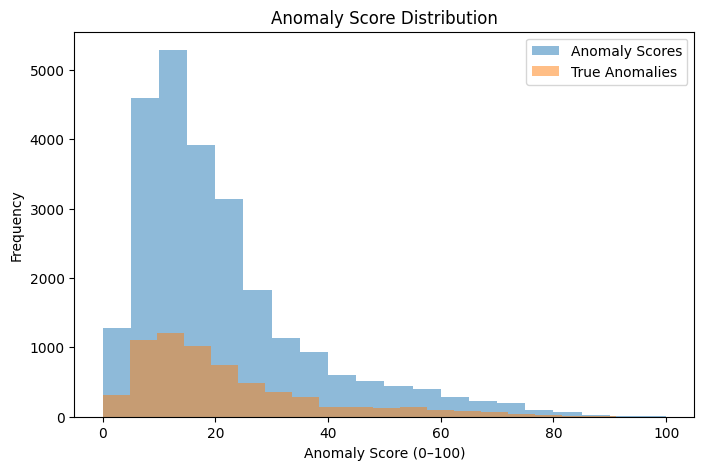

Feature correlations with anomaly score:
degree              0.297166
small_tx_count      0.255597
avg_amount          0.580619
max_amount          0.580619
amount_variance          NaN
clustering_coeff    0.216876
tx_freq_variance    0.455732
amount_skewness     0.164974
Name: anomaly_score, dtype: float64


In [47]:
# Verify database
result = conn.execute("MATCH (e:Entity) RETURN COUNT(e)")
num_entities = result.get_next()[0]
result = conn.execute("MATCH ()-[t:Transaction]->() RETURN COUNT(t)")
num_transactions = result.get_next()[0]
print(f"Number of entities: {num_entities}")
print(f"Number of transactions: {num_transactions}")
if num_entities == 0 or num_transactions == 0:
    raise ValueError("Database is empty. Ensure entities.csv and transactions.csv are loaded.")

# Query 1: Degree
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS degree
    """)
    degree_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                            columns=['entity_id', 'degree'])
    degree_df['degree'] = pd.to_numeric(degree_df['degree'], errors='coerce')
    print(f"Number of tuples in degree query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing degree query: {e}")
    raise

# Query 3: Small transaction count
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        WHERE t.amount < 1000
        RETURN e.entity_id, COUNT(t) AS small_tx_count
    """)
    small_tx_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'small_tx_count'])
    small_tx_df['small_tx_count'] = pd.to_numeric(small_tx_df['small_tx_count'], errors='coerce')
    print(f"Number of tuples in small transaction query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing small transaction query: {e}")
    raise

# Query 4: Clustering coefficient
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t1:Transaction]->(m:Entity)-[t2:Transaction]->(n:Entity)
        WHERE n.entity_id = e.entity_id
        RETURN e.entity_id, COUNT(DISTINCT m) AS clustering_coeff
    """)
    cluster_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                             columns=['entity_id', 'clustering_coeff'])
    cluster_df['clustering_coeff'] = pd.to_numeric(cluster_df['clustering_coeff'], errors='coerce')
    print(f"Number of tuples in clustering coefficient query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing clustering coefficient query: {e}")
    raise

# Query 5: Transaction frequency variance
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS tx_count
    """)
    tx_count_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'tx_count'])
    tx_count_df['tx_count'] = pd.to_numeric(tx_count_df['tx_count'], errors='coerce')
    mean_tx_count = tx_count_df['tx_count'].mean()
    tx_count_df['tx_freq_variance'] = (tx_count_df['tx_count'] - mean_tx_count) ** 2
    tx_freq_df = tx_count_df.groupby('entity_id').agg({'tx_freq_variance': 'mean'}).reset_index()
    tx_freq_df['tx_freq_variance'] = np.sqrt(tx_freq_df['tx_freq_variance']).fillna(0)
    print(f"Number of tuples in tx frequency variance query: {len(tx_count_df)}")
except Exception as e:
    print(f"Error computing tx frequency variance: {e}")
    raise

# Query 6: Amount skewness (fetch raw amounts)
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, t.amount AS amount
    """)
    skew_raw_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'amount'])
    skew_raw_df['amount'] = pd.to_numeric(skew_raw_df['amount'], errors='coerce')
    # Compute skewness per entity
    skew_df = skew_raw_df.groupby('entity_id').agg({
        'amount': [
            ('avg_amount', 'mean'),
            ('std_dev', lambda x: np.std(x, ddof=1)),
            ('skewness', lambda x: ((x - x.mean()) ** 3).mean() / (x.std(ddof=1) ** 3 + 1e-7) if len(x) > 1 else 0)
        ]
    }).droplevel(0, axis=1).reset_index()
    skew_df = skew_df[['entity_id', 'skewness']].rename(columns={'skewness': 'amount_skewness'})
    skew_df['amount_skewness'] = skew_df['amount_skewness'].fillna(0)
    print(f"Number of tuples in amount skewness query: {len(skew_df)}")
except Exception as e:
    print(f"Error computing amount skewness: {e}")
    raise

# Additional features
try:
    result = conn.execute("""
        MATCH (e:Entity)
        OPTIONAL MATCH (e)-[t:Transaction]->()
        OPTIONAL MATCH ()-[t_in:Transaction]->(e)
        WITH e, t, t_in, AVG(t.amount) AS avg_amount
        RETURN e.entity_id, 
               COALESCE(avg_amount, 0) AS avg_amount, 
               COALESCE(SUM(CASE WHEN t.is_cross_border THEN 1 ELSE 0 END) / NULLIF(COUNT(t) + 1, 1), 0) AS cross_border_ratio,
               COALESCE(MAX(t.amount), 0) AS max_amount,
               COALESCE(COUNT(t_in), 0) AS in_degree,
               COALESCE(COUNT(t), 0) AS tx_frequency,
               COALESCE(
                   SQRT(
                       SUM(CASE WHEN t.amount IS NOT NULL THEN (t.amount - avg_amount)^2 ELSE 0 END) / 
                       NULLIF(COUNT(t) + 1, 1)
                   ), 0
               ) AS amount_variance
    """)
    features_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance'])
    features_df[['avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance']] = features_df[
        ['avg_amount', 'cross_border_ratio', 'max_amount', 'in_degree', 'tx_frequency', 'amount_variance']
    ].apply(pd.to_numeric, errors='coerce')
    print(f"Number of tuples in features query: {result.get_num_tuples()}")
    print(features_df.head())
except Exception as e:
    print(f"Error executing features query: {e}")
    raise

# Merge features
data_df = degree_df.merge(small_tx_df, on='entity_id', how='left').merge(features_df, on='entity_id', how='left').merge(cluster_df, on='entity_id', how='left').merge(tx_freq_df, on='entity_id', how='left').merge(skew_df, on='entity_id', how='left')
data_df.fillna({'small_tx_count': 0, 'avg_amount': 0, 'cross_border_ratio': 0, 'max_amount': 0, 'in_degree': 0, 'tx_frequency': 0, 'amount_variance': 0, 'clustering_coeff': 0, 'tx_freq_variance': 0, 'amount_skewness': 0}, inplace=True)
print("Merged data_df:")
print(data_df.head())
print("DataFrame info:")
print(data_df.dtypes)
print("NaN counts:")
print(data_df.isna().sum())

# Compute ml_flag for evaluation
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, AVG(t.ml_flag) AS ml_flag_score
    """)
    ml_flag_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                             columns=['entity_id', 'ml_flag_score'])
    ml_flag_df['ml_flag_score'] = pd.to_numeric(ml_flag_df['ml_flag_score'], errors='coerce').fillna(0)
    data_df = data_df.merge(ml_flag_df, on='entity_id', how='left').fillna({'ml_flag_score': 0})
    data_df['is_anomaly'] = (data_df['ml_flag_score'] > 0.03).astype(int)
except Exception as e:
    print(f"Error computing ml_flag_score: {e}")
    data_df['is_anomaly'] = np.zeros(len(data_df), dtype=int)

# Feature selection
feature_columns = ['degree', 'small_tx_count', 'avg_amount', 'max_amount', 'amount_variance', 'clustering_coeff', 'tx_freq_variance', 'amount_skewness']
X = data_df[feature_columns].values

# Verify X
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values")
    print("Rows with issues:", np.where(~np.isfinite(X))[0])
    print("Columns with issues:", [feature_columns[i] for i in np.where(~np.isfinite(X))[1]])
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("X after scaling:", X[:5])
print("Any NaN in X:", np.any(np.isnan(X)))
print("Any inf in X:", np.any(np.isinf(X)))

# Isolation Forest
iso_forest = IsolationForest(contamination=0.03, random_state=42, n_estimators=300)
iso_forest.fit(X)

# Anomaly scores
anomaly_scores = -iso_forest.score_samples(X)
anomaly_scores = 100 * (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-7)
data_df['anomaly_score'] = anomaly_scores
data_df['predicted_anomaly'] = (iso_forest.predict(X) == -1).astype(int)

# Evaluate
if 'is_anomaly' in data_df.columns:
    precision = precision_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    recall = recall_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    f1 = f1_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

# K-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)
fold = 1
precisions = []
recalls = []
f1_scores = []
mean_anomaly_scores = []

for train_idx, val_idx in kf.split(X):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    iso_forest = IsolationForest(contamination=0.03, random_state=42, n_estimators=300)
    iso_forest.fit(X_train)
    
    val_scores = -iso_forest.score_samples(X_val)
    val_scores = 100 * (val_scores - val_scores.min()) / (val_scores.max() - val_scores.min() + 1e-7)
    mean_anomaly_scores.append(np.mean(val_scores))
    
    val_predictions = iso_forest.predict(X_val)
    val_predictions = (val_predictions == -1).astype(int)
    
    if 'is_anomaly' in data_df.columns:
        y_val = data_df['is_anomaly'].iloc[val_idx]
        precision = precision_score(y_val, val_predictions, zero_division=0)
        recall = recall_score(y_val, val_predictions, zero_division=0)
        f1 = f1_score(y_val, val_predictions, zero_division=0)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        print(f"Fold {fold} Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    print(f"Fold {fold} Mean Anomaly Score: {np.mean(val_scores):.4f}")
    print(f"Validation Anomaly Scores (first 10): {val_scores[:10]}")
    fold += 1

# Average metrics
if 'is_anomaly' in data_df.columns:
    print(f"\nAverage Precision: {np.mean(precisions):.4f}")
    print(f"Average Recall: {np.mean(recalls):.4f}")
    print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Mean Anomaly Score: {np.mean(mean_anomaly_scores):.4f}")

# Plot anomaly score distribution
plt.figure(figsize=(8, 5))
plt.hist(data_df['anomaly_score'], bins=20, alpha=0.5, label='Anomaly Scores')
if 'is_anomaly' in data_df.columns:
    plt.hist(data_df[data_df['is_anomaly'] == 1]['anomaly_score'], bins=20, alpha=0.5, label='True Anomalies')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score (0–100)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Feature correlations
print("Feature correlations with anomaly score:")
correlations = data_df[feature_columns + ['anomaly_score']].corr()['anomaly_score'].drop('anomaly_score')
print(correlations)

# Save results
data_df.to_csv('anomaly_results.csv', index=False)

Creating new Kuzu database
Number of entities: 5000
Number of transactions: 25000
Number of tuples in degree query: 4970
Number of tuples in small transaction query: 2955
Number of tuples in clustering coefficient query: 28
Number of tuples in tx frequency variance query: 4970
Number of tuples in amount variance/skewness query: 4970
Number of tuples in features query: 5000
Merged data_df:
  entity_id  degree  small_tx_count    avg_amount  amount_variance  \
0     E2113       6             0.0  11411.412053     7.972827e+07   
1     E2616       4             0.0  10765.618435     9.693413e+07   
2     E4282       4             1.0   1782.342515     7.945202e+05   
3     E1290       4             2.0   3214.105637     2.098442e+07   
4     E2311       9             5.0   3801.241843     3.190800e+07   

   amount_skewness  clustering_coeff  tx_freq_variance  cross_border_amount  \
0         0.185425               0.0          0.969819         28498.993019   
1         0.425014           

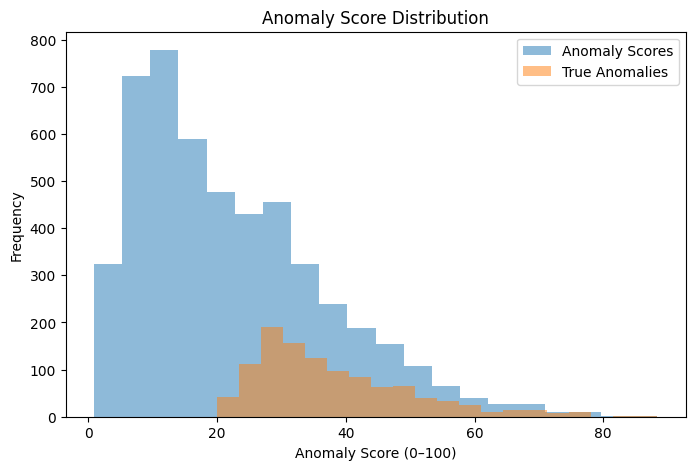

Feature correlations with anomaly score:
degree                 0.404314
small_tx_count         0.285572
avg_amount             0.345962
amount_variance        0.437799
amount_skewness        0.284506
clustering_coeff       0.144792
tx_freq_variance       0.302245
cross_border_amount    0.445919
Name: anomaly_score, dtype: float64


In [50]:
import pandas as pd
import numpy as np
import kuzu
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import os

# Synthetic data generation
def generate_synthetic_data(num_entities=5000, num_transactions=25000):
    np.random.seed(42)
    entities = pd.DataFrame({'entity_id': [f'E{i:04d}' for i in range(num_entities)]})
    suspicious = np.random.choice([0, 1], num_entities, p=[0.9, 0.1])
    transactions = pd.DataFrame({
        'sender_id': np.random.choice(entities['entity_id'], num_transactions),
        'receiver_id': np.random.choice(entities['entity_id'], num_transactions),
        'amount': np.random.exponential(15000, num_transactions).clip(100, 300000),
        'is_cross_border': np.random.choice([True, False], num_transactions, p=[0.2, 0.8]),
        'ml_flag': np.zeros(num_transactions)
    })
    for i, row in entities.iterrows():
        if suspicious[i]:
            mask = transactions['sender_id'] == row['entity_id']
            transactions.loc[mask, 'ml_flag'] = np.random.choice([0, 1], sum(mask), p=[0.3, 0.7])
    transactions['amount'] = np.where(
        transactions['ml_flag'] == 1,
        np.random.exponential(800, num_transactions).clip(10, 200),
        transactions['amount']
    )
    transactions['is_cross_border'] = np.where(
        transactions['ml_flag'] == 1,
        np.random.choice([True, False], num_transactions, p=[0.95, 0.05]),
        transactions['is_cross_border']
    )
    entities.to_csv('entities.csv', index=False)
    transactions.to_csv('transactions.csv', index=False)
    print(f"Generated {num_entities} entities and {num_transactions} transactions")
    print(transactions['amount'].describe())
    print(transactions['is_cross_border'].value_counts())
    print(transactions['ml_flag'].value_counts())

# Uncomment to regenerate synthetic data
# generate_synthetic_data()

# Connect to Kuzu database
db_path = 'kuzu_db'
if not os.path.exists(db_path):
    print("Creating new Kuzu database")
    db = kuzu.Database(db_path)
    conn = kuzu.Connection(db)
    conn.execute("CREATE NODE TABLE Entity(entity_id STRING, PRIMARY KEY(entity_id))")
    conn.execute("CREATE REL TABLE Transaction(FROM Entity TO Entity, amount DOUBLE, is_cross_border BOOLEAN, ml_flag INT)")
    conn.execute("COPY Entity FROM 'entities.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
    conn.execute("COPY Transaction FROM 'transactions.csv' (HEADER=TRUE, DELIM=',', QUOTE='\"')")
else:
    print("Connecting to existing Kuzu database")
    db = kuzu.Database(db_path)
    conn = kuzu.Connection(db)

# Verify database
result = conn.execute("MATCH (e:Entity) RETURN COUNT(e)")
num_entities = result.get_next()[0]
result = conn.execute("MATCH ()-[t:Transaction]->() RETURN COUNT(t)")
num_transactions = result.get_next()[0]
print(f"Number of entities: {num_entities}")
print(f"Number of transactions: {num_transactions}")
if num_entities == 0 or num_transactions == 0:
    raise ValueError("Database is empty.")

# Query 1: Degree
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS degree
    """)
    degree_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                            columns=['entity_id', 'degree'])
    degree_df['degree'] = pd.to_numeric(degree_df['degree'], errors='coerce')
    print(f"Number of tuples in degree query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing degree query: {e}")
    raise

# Query 3: Small transaction count
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        WHERE t.amount < 1000
        RETURN e.entity_id, COUNT(t) AS small_tx_count
    """)
    small_tx_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'small_tx_count'])
    small_tx_df['small_tx_count'] = pd.to_numeric(small_tx_df['small_tx_count'], errors='coerce')
    print(f"Number of tuples in small transaction query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing small transaction query: {e}")
    raise

# Query 4: Clustering coefficient
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t1:Transaction]->(m:Entity)-[t2:Transaction]->(n:Entity)
        WHERE n.entity_id = e.entity_id
        RETURN e.entity_id, COUNT(DISTINCT m) AS clustering_coeff
    """)
    cluster_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                             columns=['entity_id', 'clustering_coeff'])
    cluster_df['clustering_coeff'] = pd.to_numeric(cluster_df['clustering_coeff'], errors='coerce')
    print(f"Number of tuples in clustering coefficient query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing clustering coefficient query: {e}")
    raise

# Query 5: Transaction frequency variance
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, COUNT(t) AS tx_count
    """)
    tx_count_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'tx_count'])
    tx_count_df['tx_count'] = pd.to_numeric(tx_count_df['tx_count'], errors='coerce')
    mean_tx_count = tx_count_df['tx_count'].mean()
    tx_count_df['tx_freq_variance'] = (tx_count_df['tx_count'] - mean_tx_count) ** 2
    tx_freq_df = tx_count_df.groupby('entity_id').agg({'tx_freq_variance': 'mean'}).reset_index()
    tx_freq_df['tx_freq_variance'] = np.sqrt(tx_freq_df['tx_freq_variance']).fillna(0)
    print(f"Number of tuples in tx frequency variance query: {len(tx_count_df)}")
except Exception as e:
    print(f"Error computing tx frequency variance: {e}")
    raise

# Query 6: Amount variance and skewness
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, t.amount AS amount
    """)
    amount_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                            columns=['entity_id', 'amount'])
    amount_df['amount'] = pd.to_numeric(amount_df['amount'], errors='coerce')
    var_skew_df = amount_df.groupby('entity_id').agg({
        'amount': [
            ('avg_amount', 'mean'),
            ('amount_variance', lambda x: np.var(x, ddof=1) if len(x) > 1 else 0),
            ('amount_skewness', lambda x: ((x - x.mean()) ** 3).mean() / (x.std(ddof=1) ** 3 + 1e-7) if len(x) > 1 else 0)
        ]
    }).droplevel(0, axis=1).reset_index()
    var_skew_df[['amount_variance', 'amount_skewness']] = var_skew_df[['amount_variance', 'amount_skewness']].fillna(0)
    print(f"Number of tuples in amount variance/skewness query: {len(var_skew_df)}")
except Exception as e:
    print(f"Error computing amount variance/skewness: {e}")
    raise

# Query for transaction velocity and burstiness
result = conn.execute("""
    MATCH (e:Entity)-[t:Transaction]->()
    RETURN e.entity_id, t.timestamp AS timestamp
""")
time_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                       columns=['entity_id', 'timestamp'])
time_df['timestamp'] = pd.to_numeric(time_df['timestamp'], errors='coerce')
time_agg_df = time_df.groupby('entity_id').agg({
    'timestamp': [
        ('tx_velocity', lambda x: len(x) / (x.max() - x.min() + 1e-7)),
        ('burstiness', lambda x: np.var(x, ddof=1) if len(x) > 1 else 0)
    ]
}).droplevel(0, axis=1).reset_index()
time_agg_df[['tx_velocity', 'burstiness']] = time_agg_df[['tx_velocity', 'burstiness']].fillna(0)
data_df = data_df.merge(time_agg_df, on='entity_id', how='left').fillna({'tx_velocity': 0, 'burstiness': 0})
feature_columns.extend(['tx_velocity', 'burstiness'])

# Additional features
try:
    result = conn.execute("""
        MATCH (e:Entity)
        OPTIONAL MATCH (e)-[t:Transaction]->()
        OPTIONAL MATCH ()-[t_in:Transaction]->(e)
        RETURN e.entity_id, 
               COALESCE(SUM(CASE WHEN t.is_cross_border THEN t.amount ELSE 0 END), 0) AS cross_border_amount,
               COALESCE(COUNT(t_in), 0) AS in_degree,
               COALESCE(COUNT(t), 0) AS tx_frequency
    """)
    features_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                              columns=['entity_id', 'cross_border_amount', 'in_degree', 'tx_frequency'])
    features_df[['cross_border_amount', 'in_degree', 'tx_frequency']] = features_df[
        ['cross_border_amount', 'in_degree', 'tx_frequency']
    ].apply(pd.to_numeric, errors='coerce')
    print(f"Number of tuples in features query: {result.get_num_tuples()}")
except Exception as e:
    print(f"Error executing features query: {e}")
    raise

# Merge features
data_df = degree_df.merge(small_tx_df, on='entity_id', how='left').merge(var_skew_df, on='entity_id', how='left').merge(cluster_df, on='entity_id', how='left').merge(tx_freq_df, on='entity_id', how='left').merge(features_df, on='entity_id', how='left')
data_df.fillna({'small_tx_count': 0, 'avg_amount': 0, 'amount_variance': 0, 'amount_skewness': 0, 'clustering_coeff': 0, 'tx_freq_variance': 0, 'cross_border_amount': 0, 'in_degree': 0, 'tx_frequency': 0}, inplace=True)
print("Merged data_df:")
print(data_df.head())
print("NaN counts:")
print(data_df.isna().sum())

# Compute ml_flag and ordinal classes
try:
    result = conn.execute("""
        MATCH (e:Entity)-[t:Transaction]->()
        RETURN e.entity_id, AVG(t.ml_flag) AS ml_flag_score
    """)
    ml_flag_df = pd.DataFrame([result.get_next() for _ in range(result.get_num_tuples())], 
                             columns=['entity_id', 'ml_flag_score'])
    ml_flag_df['ml_flag_score'] = pd.to_numeric(ml_flag_df['ml_flag_score'], errors='coerce').fillna(0)
    data_df = data_df.merge(ml_flag_df, on='entity_id', how='left').fillna({'ml_flag_score': 0})
    # Ordinal classes: Low (0–0.03), Medium (0.03–0.1), High (>0.1)
    data_df['risk_class'] = pd.cut(data_df['ml_flag_score'], 
                                  bins=[-np.inf, 0.03, 0.1, np.inf], 
                                  labels=[0, 1, 2], 
                                  include_lowest=True).astype(int)
    data_df['is_anomaly'] = (data_df['ml_flag_score'] > 0.03).astype(int)
except Exception as e:
    print(f"Error computing ml_flag_score: {e}")
    data_df['risk_class'] = np.zeros(len(data_df), dtype=int)
    data_df['is_anomaly'] = np.zeros(len(data_df), dtype=int)

# Feature selection
feature_columns = ['degree', 'small_tx_count', 'avg_amount', 'amount_variance', 'amount_skewness', 'clustering_coeff', 'tx_freq_variance', 'cross_border_amount']
X = data_df[feature_columns].values

# Verify X
if not np.all(np.isfinite(X)):
    print("Warning: X contains non-finite values")
    print("Rows with issues:", np.where(~np.isfinite(X))[0])
    print("Columns with issues:", [feature_columns[i] for i in np.where(~np.isfinite(X))[1]])
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standard scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Any NaN in X:", np.any(np.isnan(X)))
print("Any inf in X:", np.any(np.isinf(X)))

# Hybrid model: Random Forest + Isolation Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
iso_forest = IsolationForest(contamination=0.03, random_state=42, n_estimators=300)

# Train and predict
rf.fit(X, data_df['risk_class'])
iso_forest.fit(X)
rf_probs = rf.predict_proba(X)[:, 2]  # Probability of High risk
anomaly_scores = -iso_forest.score_samples(X)
anomaly_scores = 100 * (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-7)
# Combine scores (weighted sum)
combined_scores = 0.7 * anomaly_scores + 30 * rf_probs
data_df['anomaly_score'] = combined_scores
data_df['predicted_anomaly'] = (combined_scores > 50).astype(int)

# Evaluate
if 'is_anomaly' in data_df.columns:
    precision = precision_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    recall = recall_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    f1 = f1_score(data_df['is_anomaly'], data_df['predicted_anomaly'], zero_division=0)
    print(f"Overall Precision: {precision:.4f}")
    print(f"Overall Recall: {recall:.4f}")
    print(f"Overall F1 Score: {f1:.4f}")

# K-fold cross-validation
kf = KFold(n_splits=7, shuffle=True, random_state=42)
fold = 1
precisions = []
recalls = []
f1_scores = []
mean_anomaly_scores = []

for train_idx, val_idx in kf.split(X):
    print(f"\nFold {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train = data_df['risk_class'].iloc[train_idx]
    y_val = data_df['is_anomaly'].iloc[val_idx]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    iso_forest = IsolationForest(contamination=0.03, random_state=42, n_estimators=300)
    rf.fit(X_train, y_train)
    iso_forest.fit(X_train)
    
    rf_probs = rf.predict_proba(X_val)[:, 2]
    val_scores = -iso_forest.score_samples(X_val)
    val_scores = 100 * (val_scores - val_scores.min()) / (val_scores.max() - val_scores.min() + 1e-7)
    combined_val_scores = 0.7 * val_scores + 30 * rf_probs
    val_predictions = (combined_val_scores > 50).astype(int)
    
    precision = precision_score(y_val, val_predictions, zero_division=0)
    recall = recall_score(y_val, val_predictions, zero_division=0)
    f1 = f1_score(y_val, val_predictions, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    mean_anomaly_scores.append(np.mean(combined_val_scores))
    
    print(f"Fold {fold} Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    print(f"Fold {fold} Mean Anomaly Score: {np.mean(combined_val_scores):.4f}")
    print(f"Validation Anomaly Scores (first 10): {combined_val_scores[:10]}")
    fold += 1

# Average metrics
print(f"\nAverage Precision: {np.mean(precisions):.4f}")
print(f"Average Recall: {np.mean(recalls):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
print(f"Average Mean Anomaly Score: {np.mean(mean_anomaly_scores):.4f}")

# Plot anomaly score distribution
plt.figure(figsize=(8, 5))
plt.hist(data_df['anomaly_score'], bins=20, alpha=0.5, label='Anomaly Scores')
plt.hist(data_df[data_df['is_anomaly'] == 1]['anomaly_score'], bins=20, alpha=0.5, label='True Anomalies')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score (0–100)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Feature correlations
print("Feature correlations with anomaly score:")
correlations = data_df[feature_columns + ['anomaly_score']].corr()['anomaly_score'].drop('anomaly_score')
print(correlations)

# Save results
data_df.to_csv('anomaly_results.csv', index=False)